#Fit two step task with an associative algorithm

In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import patsy
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from sklearn import linear_model
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
%matplotlib inline

In [2]:
alpha = .45 #learning rate
m=3.0 #temperature (not inverse)
p=.4 #tendency to repeat actions >1 means perseveration (from Daw 2011)

#Helper RL functions

In [3]:
#set up data structures and initialize reward and transition probabilities
def initialize():
    #define relevant objects
    objects = ['a1','a2','b1','b2','c1','c2']
    states = ['a','b','c','terminal']
    actions = ['1','2']

    #initialize empty data structures
    transitions = {s2: {a : {s1 : 0 for s1 in states} for a in actions} for s2 in states}
    rewards = {s: {a : 0 for a in actions} for s in states}
    associations = {o1: {o2 : 0 for o2 in objects if o1!=o2} for o1 in objects}
    V = {key: 0 for key in objects}
      
    #fill in transition probabilities
    for s in ['b','c']: #all actions lead to terminal state
        for a in actions:
            transitions[s][a]['terminal'] = 1
    transitions['a']['1']['b'] = .7
    transitions['a']['1']['c'] = .3
    transitions['a']['2']['b'] = .3
    transitions['a']['2']['c'] = .7

    #set up reward probs
    rewards['b']['1'] = .6
    rewards['b']['2'] = .4
    rewards['c']['1'] = .4
    rewards['c']['2'] = .6
    
    return transitions, rewards, V, associations, objects, states, actions

In [4]:
#gradually shift reward probabilitites to encourage learning
def update_rewards(rewards):
    for s in ['b','c']: #only update end states
        for a in actions:
            shift = np.random.normal(0,.025)
            if (rewards[s][a] + shift > .75) or (rewards[s][a] + shift < .25): #reflecting boundaries
                rewards[s][a] = rewards[s][a] - shift
            else:
                rewards[s][a] = rewards[s][a] + shift
    return rewards

In [5]:
#draw a reward according to reward probability functions
def get_reward(state,action,rewards):
    return scipy.stats.bernoulli.rvs(rewards[state][action])

In [6]:
#get new state according to state, action, and transition probabilities
def next_state(state,action): 
    probs = map(lambda x: transitions[state][action][x], states)
    return np.random.choice(a=states,p=probs)

In [7]:
#pick an action according to softmax
def get_action(state,V,last_a_action):
    Vs = map(lambda a: V[state+a],actions) #get values of each object in state
    if state == 'a': #model perseveration
        if last_a_action == '1':
            Vs[0] = Vs[0] + p
        else:
            Vs[1] = Vs[1] + p
    normalizing_constant = np.sum(map(lambda v: np.exp(m*v),Vs)) #get total value of state
    probs = map(lambda v: np.exp(v*m), Vs)
    probs = probs / normalizing_constant
    return np.random.choice(a=actions,p=probs)

In [8]:
#every time a transition occurs, increment the association between those two objects
def update_associations(state,new_state,action,associations, nsteps):
    if new_state != 'terminal':
        nsteps +=1
        for a in actions:
            associations[state + action][new_state + a] = associations[state + action][new_state + a] + 1
            associations[new_state + a][state + action] = associations[state + action][new_state + a] #make symmetric
    return associations, nsteps

In [16]:
def update_value(rew,state,new_state,action,V,associations,nsteps):
#Not sure whether to have value updated between first and second-stage choices. Doesn't seem to influence results one way or another
#     if new_state != 'terminal':
#         delta = rew + max(V[new_state + actions[0]],V[new_state + actions[1]]) - V[state+action]
#     else:
#         delta = rew - V[state+action]
    delta = rew - V[state+action]
    V[state+action] = V[state+action] + alpha*delta
    
    #percolate value one step back, weighted by the strength of association
    for o in associations[state+action]:
        delta = rew - V[o]
        V[o] = V[o] + associations[state+action][o] * alpha* delta *4/ nsteps #4/nsteps is to normalize 
    return V

#Run simulation

In [17]:
#Runs through the MDP until terminal state, keeping track of the output
def take_step(state,rewards,associations,V,nsteps,output,last_a_action):
    if state == 'terminal': #end state
        rewards = update_rewards(rewards)
        return rewards, associations, V, nsteps 

    #do standard MDP stuff
    action = get_action(state,V,last_a_action)
    new_state = next_state(state,action)
    rew = get_reward(state,action,rewards)
    if state == 'a':
        last_a_action = action
        
    #log what's happening
    output['rew'].append(rew)
    output['action'].append(action)
    output['newstate'].append(new_state)
    output['state'].append(state)
    
    #update values and associations
    associations,nsteps = update_associations(state,new_state,action,associations,nsteps) #update associations
    value = update_value(rew,state,new_state,action,V,associations,nsteps)
    
    return take_step(new_state,rewards,associations,V,nsteps,output,last_a_action) #recurse until terminal state

In [18]:
#Main simulation code
ntrials = 5000
transitions, rewards, V, associations, objects, states, actions = initialize()
nsteps = 0.0
last_a_action = '1' #need one to get started
output = {'state':[],'action':[],'newstate':[],'rew':[]}
for i in range(ntrials):
    rewards, associations, V, nsteps = take_step('a',rewards,associations,V,nsteps,output,last_a_action)

#Analyze output by transition type and stay/shift behavior

In [1]:
#analyze wherer transition was common or rare
output['transition_type'] = []
for n,s in enumerate(output['newstate']):
    if s  == 'terminal':
        output['transition_type'].append('end')
    elif (s == 'b' and output['action'][n] == '1') or (s == 'c' and output['action'][n] == '2'):
        output['transition_type'].append('common')
    elif (s == 'b' and output['action'][n] == '2') or (s == 'c' and output['action'][n] == '1'):
        output['transition_type'].append('rare')
output = pd.DataFrame(output)

NameError: name 'output' is not defined

In [20]:
#calculate whether a first level action was stay or switch stay and switch
output['stay'] = np.nan
a_indices =  output[output['state'] == 'a'].index
a_indices = a_indices.values
stay_or_switch = ['np.nan']
for n,idx in enumerate(a_indices):
    if n>0:
        last_action = output.iloc[a_indices[n-1]].action
        current_action = output.iloc[a_indices[n]].action
        if last_action == current_action:
            stay_or_switch.append('stay')
        else:
            stay_or_switch.append('switch')
output.ix[output['state'] == 'a','stay']  = stay_or_switch

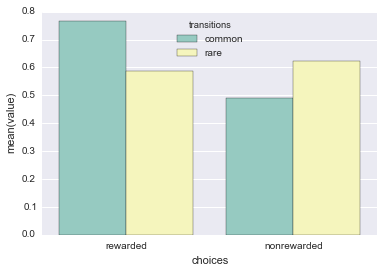

In [21]:
#parse (and plot) results
out = {'transitions' : [], 'choices' :[], 'value' : []}
for r in ['rewarded','nonrewarded']:
    if r == 'rewarded':
        rew = 1
    else:
        rew = 0
        
    indices = output[(output['newstate']=='terminal') & (output['rew'] == rew)].index[:-1] #indices of terminal state
    transition_type = output.iloc[indices-1]['transition_type'].values #common or rare
    action = output.iloc[indices+1]['stay'].values #stay or switch
    
    for c in ['common','rare']:
        choices = list(action[transition_type == c])        
        out['transitions'].append(c)
        out['choices'].append(r)
        out['value'].append(choices.count('stay')/float(len(choices)))

        
out = pd.DataFrame(out)      
sns.barplot(x='choices',y='value',hue='transitions',data=out,palette='Set3')

In [15]:
#Loook at associations and values learning
for o1 in associations:
    for o2 in associations:
        if o1 != o2:
            print o1,o2,associations[o1][o2]/nsteps
print V

a1 a2 0.0
a1 b1 0.7028
a1 b2 0.7028
a1 c2 0.2968
a1 c1 0.2968
a2 a1 0.0
a2 b1 0.0
a2 b2 0.0
a2 c2 0.0004
a2 c1 0.0004
b1 a1 0.7028
b1 a2 0.0
b1 b2 0.0
b1 c2 0.0
b1 c1 0.0
b2 a1 0.7028
b2 a2 0.0
b2 b1 0.0
b2 c2 0.0
b2 c1 0.0
c2 a1 0.2968
c2 a2 0.0004
c2 b1 0.0
c2 b2 0.0
c2 c1 0.0
c1 a1 0.2968
c1 a2 0.0004
c1 b1 0.0
c1 b2 0.0
c1 c2 0.0
{'a1': nan, 'a2': nan, 'b1': nan, 'b2': nan, 'c2': nan, 'c1': nan}
